- DON’T DECAY THE LEARNING RATE, INCREASE THE BATCH SIZE
  - [pdf](https://arxiv.org/pdf/1711.00489v1.pdf)

In [227]:
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from functools import reduce
import os
import sys
import shutil
from cifar import read_data_sets, onehot_to_names

In [2]:
print(tf.__version__)

1.3.0


In [96]:
!nvidia-smi

Wed Nov 22 04:57:27 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 370.28                 Driver Version: 370.28                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 980 Ti  Off  | 0000:02:00.0     Off |                  N/A |
|  0%   55C    P8    33W / 275W |   5916MiB /  6076MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
cifar_data = read_data_sets("data", one_hot=True)

cifar data directory found data/cifar-10-batches-py
loading data...
dtype is float, normalize images to [0, 1]
dtype is float, normalize images to [0, 1]
dtype is float, normalize images to [0, 1]


In [4]:
cifar_data.train.num_examples

45241

In [5]:
cifar_data.validation.num_examples

4759

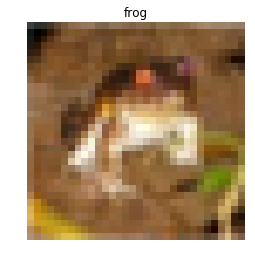

In [6]:
plt.axis('off')
plt.title(onehot_to_names(cifar_data.train.labels[0])[0])
plt.imshow(cifar_data.train.images[0].reshape((32, 32, 3)))

In [7]:
cifar_data.train.labels[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])

In [8]:
def get_conv_filter(width, height, in_channels, out_channels,
                     dtype=tf.float32, initializer=None, seed=None, name=None):
    """
    arguments
    =========
    - width: int, filter width
    - height: int, filter height
    - in_channels: int, input channel
    - out_channels: int, output channel
    - dtype: data type
    - initializer: filter initializer
    - seed: random seed of the initializer
    """
    if initializer is None:
        initializer = tf.glorot_normal_initializer(seed=seed, dtype=dtype)
    filter_shape = [width, height, in_channels, out_channels]
    return tf.Variable(initializer(shape=filter_shape), name=name)

In [110]:
def build_model(images_batch, num_class=10, graph=None):
    """
    Simple VGG-like model
    
    Arguments
    =========
    - images_batch: placeholder for batch images (NHWC)
    - graph: the graph to build model within.
    """
    if graph is None:
        graph = images_batch.graph
    
    initializer = tf.glorot_normal_initializer(dtype=tf.float32)
    with graph.as_default():
        # conv1
        with tf.name_scope("conv1"):
            filter_1 = get_conv_filter(3, 3, 3, 32, 
                                       name="filter", 
                                       initializer=initializer)
            fmap1 = tf.nn.conv2d(images_batch, filter_1, 
                                 strides=[1, 2, 2, 1],
                                 padding="VALID", name="feature_map")
            act1 = tf.nn.relu(fmap1, name="activation")
    
        # conv2
        with tf.name_scope("conv2"):
            filter_2 = get_conv_filter(3, 3, 32, 32, 
                                       name="filter", 
                                       initializer=initializer)
            fmap2 = tf.nn.conv2d(act1, filter_2,
                                 strides=[1, 2, 2, 1],
                                 padding="VALID", name="feature_map")
            act2 = tf.nn.relu(fmap2, name="activation")
    
        # max_pool
        with tf.name_scope("pool1"):
            pool = tf.nn.max_pool(act2, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding="VALID")
            
        # 1x1 conv
        with tf.name_scope("conv3_1_by_1"):
            filter_3 = get_conv_filter(1, 1, 32, 16, 
                                       name="filter", 
                                       initializer=initializer)
            fmap3 = tf.nn.conv2d(pool, filter_3,
                                 strides=[1, 1, 1, 1],
                                 padding="SAME", name="feature_map")
            
        # fc layer
        fc_dim = reduce(lambda acc, d: acc*d, fmap3.shape.as_list()[1:], 1)
        with tf.name_scope("fc1"):
            flat_fmap3 = tf.reshape(fmap3, [-1, fc_dim])
            w1 = tf.Variable(initializer(shape=[fc_dim, 512]), 
                             dtype=tf.float32,
                             name="weight")
            b1 = tf.Variable(np.zeros(512), dtype=tf.float32, name="bias")
            z1 = tf.nn.bias_add(tf.matmul(flat_fmap3, w1), b1, name="z_score")
            act_fc1 = tf.nn.relu(z1)
        
        with tf.name_scope("fc2"):
            w2 = tf.Variable(initializer(shape=[512, num_class]),
                             dtype=tf.float32,
                             name="weight")
            b2 = tf.Variable(np.zeros(num_class), dtype=tf.float32, name="bias")
            logits = tf.nn.bias_add(tf.matmul(act_fc1, w2), b2, name="logits")
        with tf.name_scope("prediction"):
            prob = tf.nn.softmax(logits, name="probability")
            pred = tf.argmax(prob, axis=1, name="pred_label")
    return graph, logits, prob, pred

In [111]:
class ValueUpdator(object):
    
    def __init__(self, init_value, grow_rate):
        self.grow_rate = grow_rate
        self._current_value = init_value
        self._init_value = init_value
    
    def get_current_value(self, max_value=None, dtype=int):
        if max_value and self._current_value >= max_value:
            current_value = max_value
            self._current_value = max_value
        else:
            current_value = self._current_value
            self._current_value *= self.grow_rate
        return dtype(current_value)
    
    def reset(self):
        self._current_value = self._init_value
    
    def __str__(self):
        return "ValueUpdator: {}".format(self._current_value)

In [112]:
x = np.arange(0, 500)
y = 50*np.array(1.011)**x

In [113]:
y[400]

3975.8705951757797

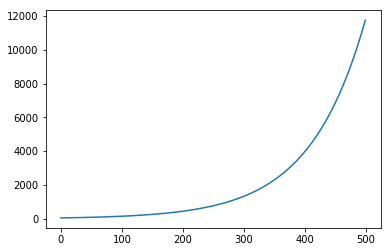

In [114]:
plt.plot(x, y)

In [115]:
batch_updator = ValueUpdator(50, 1.011) # grow the size by 1.2% for every batch

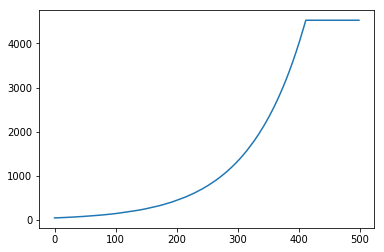

In [116]:
plt.plot([batch_updator.get_current_value(max_value=4524) for _ in range(500)])

----

## Check Model

- overfitting on a small dataset

In [117]:
def accuracy(y, y_):
    return (y == y_).mean()

In [118]:
graph = tf.Graph()
with graph.as_default():
    tf_image_batch = tf.placeholder(tf.float32, 
                                    [None, 32, 32, 3], 
                                    name="image_batch")
_, tf_logits, tf_prob, tf_pred = build_model(tf_image_batch, graph=graph)

In [119]:
with graph.as_default():
    # cross-entropy loss
    tf_labels = tf.placeholder(tf.float32, shape=[None, 10], name="true_labels")
    with tf.name_scope("loss"):
        tf_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=tf_logits,
                                                             labels=tf_labels,
                                                             name="entropy")
        tf_loss = tf.reduce_mean(tf_entropy, name="mean_loss")
    
    # training
    train_op = tf.train.GradientDescentOptimizer(0.01).minimize(tf_loss, name="minimize")

In [120]:
if os.path.exists("log/simple_cnn"):
    print("remove old log directory")
    shutil.rmtree("log/simple_cnn")

tf.summary.FileWriter(logdir="log/simple_cnn", graph=graph).close()

remove old log directory


![simple-cnn](images/simple_cnn.png)

In [121]:
# a small batch of data
cifar_data = read_data_sets("data", one_hot=True)
sb_images, sb_labels = cifar_data.train.next_batch(1000)
sb_images = sb_images.reshape((-1, 32, 32, 3))

cifar data directory found data/cifar-10-batches-py
loading data...
dtype is float, normalize images to [0, 1]
dtype is float, normalize images to [0, 1]
dtype is float, normalize images to [0, 1]


In [122]:
num_iters = 4000
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    
    feed_dict = {tf_image_batch: sb_images,
                 tf_labels: sb_labels}
    true_pred = np.argmax(sb_labels, axis=1)
    for step in range(1, num_iters+1):
        _, loss, pred = sess.run([train_op, tf_loss, tf_pred], feed_dict=feed_dict)
        if step % 500 == 0:
            print("step:", step)
            print("loss:", loss)
            print("  accuracy:", accuracy(pred, true_pred))

step: 500
loss: 2.00309
  accuracy: 0.288
step: 1000
loss: 1.66171
  accuracy: 0.43
step: 1500
loss: 1.3359
  accuracy: 0.529
step: 2000
loss: 0.929563
  accuracy: 0.692
step: 2500
loss: 0.442397
  accuracy: 0.875
step: 3000
loss: 0.0777538
  accuracy: 0.999
step: 3500
loss: 0.0279402
  accuracy: 1.0
step: 4000
loss: 0.0145205
  accuracy: 1.0


Ok, it seems like my model now can overfit small data.

So my model capacity should be OK.....Maybe XDD

Let's go for more training!

-----

## Learning Rate Decay

- "batch size is constant"
- "learning rate repeatedly decays by a factor of 5 at a sequence of steps"
  - It seems like they decrease the learning rate by factor 5 at every steps, but according to my experience it may be too aggressive for my simple cnn.
  - So I decide to not to do exactly as what the paper did here.

In [245]:
lrd_graph = tf.Graph()
with lrd_graph.as_default():
    # placeholders
    lrd_image_batch = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name="images")
    lrd_labels = tf.placeholder(tf.float32, shape=[None, 10], name="labels")
    lrd_learn_rate = tf.placeholder(tf.float32, name="learn_rate")
_, lrd_logits, lrd_prob, lrd_pred = build_model(lrd_image_batch, graph=lrd_graph)

with lrd_graph.as_default():
    # cross-entropy loss
    with tf.name_scope("loss"):
        lrd_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=lrd_logits,
                                                              labels=lrd_labels,
                                                              name="entropy")
        lrd_loss = tf.reduce_mean(lrd_entropy, name="mean_loss")
    # training
    lrd_train_op = tf.train.GradientDescentOptimizer(lrd_learn_rate).minimize(lrd_loss, name="minimize")
    
    # summarize gradients
    with tf.name_scope("summarize"):
        grads = tf.gradients(lrd_loss, tf.trainable_variables())
        for grad in grads:
            tf.summary.histogram(grad.op.name, grad)
        summary_all = tf.summary.merge_all()

In [246]:
num_epochs = 150
batch_size = 128
lr_init = 0.1
lr_decay = 0.9

logdir = "log/lrd_graph/lr_{}_{}".format(lr_init, lr_decay)
if os.path.exists(logdir):
    print("remove old log directory:", logdir)
    shutil.rmtree(logdir)
train_writer = tf.summary.FileWriter(logdir=logdir, graph=lrd_graph)

remove old log directory: log/lrd_graph/lr_0.1_0.9


In [247]:
lrd_loss_history = []
lrd_test_acc_history = []
data_set = read_data_sets("data", one_hot=True)

lr_updator = ValueUpdator(init_value=lr_init, grow_rate=lr_decay)
test_images = data_set.test.images.reshape((-1, 32, 32, 3))
test_pred = np.argmax(data_set.test.labels, axis=1)
log_file = open(os.path.join(logdir, "train_log.txt"), "w")

try:
    with tf.Session(graph=lrd_graph) as sess:
        tf.global_variables_initializer().run()

        for epoch in range(1, num_epochs+1):
            current_epoch = data_set.train.epochs_completed
            current_lr = lr_updator.get_current_value(dtype=float)
            print("current learning rate:", current_lr, file=log_file, flush=True)
            batch_count = 0
            while data_set.train.epochs_completed <= current_epoch:
                batch_images, batch_labels = data_set.train.next_batch(batch_size)
                batch_images = batch_images.reshape((-1, 32, 32, 3))
                batch_count += 1
                feed_dict = {lrd_image_batch: batch_images,
                             lrd_labels: batch_labels,
                             lrd_learn_rate: current_lr}
                _, loss = sess.run([lrd_train_op, lrd_loss], feed_dict=feed_dict)
                lrd_loss_history.append(loss) # collect all batch training loss
                if batch_count % 500 == 0:
                    # logging validation loss and accuracy
                    feed_dict = {lrd_image_batch: data_set.validation.images.reshape((-1, 32, 32, 3)),
                                 lrd_labels: data_set.validation.labels}
                    pred = sess.run(lrd_pred, feed_dict=feed_dict)
                    true_pred = np.argmax(data_set.validation.labels, axis=1)
                    print("batch count:", batch_count, file=log_file, flush=True)
                    print("  loss:", loss, file=log_file, flush=True)
                    print("  accuracy:", accuracy(pred, true_pred), file=log_file, flush=True)
            summ_all = sess.run(summary_all, feed_dict=feed_dict)
            train_writer.add_summary(summ_all, epoch)
            # compute test accuracy
            feed_dict = {lrd_image_batch: data_set.test.images.reshape((-1, 32, 32, 3)),
                         lrd_labels: data_set.test.labels}
            loss, pred = sess.run([lrd_loss, lrd_pred], feed_dict=feed_dict)
            acc = accuracy(pred, test_pred)
            lrd_test_acc_history.append(acc)
            print("epoch {} done".format(epoch), file=log_file, flush=True)
            print("  test loss: {:.2f}".format(loss), file=log_file, flush=True)
            print("  accuracy: {:.4f}".format(acc), file=log_file, flush=True)
except BaseException as e:
    print(type(e))
    print(e)
finally:
    if not log_file is sys.stdout:
        print("clossing {}".format(log_file.name))
        log_file.close()

cifar data directory found data/cifar-10-batches-py
loading data...
dtype is float, normalize images to [0, 1]
dtype is float, normalize images to [0, 1]
dtype is float, normalize images to [0, 1]
clossing log/lrd_graph/lr_0.1_0.9/train_log.txt


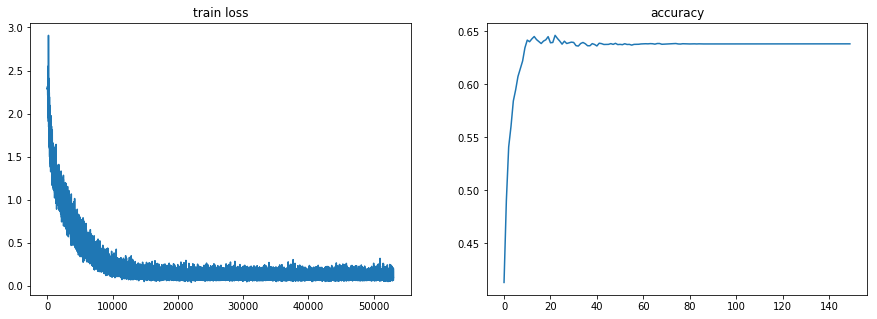

In [255]:
plt.subplot(1, 2, 1)
plt.title("train loss")
plt.plot(lrd_loss_history)

plt.subplot(1, 2, 2)
plt.title("accuracy")
plt.plot(lrd_test_acc_history)
fig = plt.gcf()
fig.set_size_inches((15, 5))

----

## Increasing Batch Size 

In [256]:
ibs_graph = tf.Graph()
with ibs_graph.as_default():
    # placeholders
    ibs_image_batch = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name="images")
    ibs_labels = tf.placeholder(tf.float32, shape=[None, 10], name="labels")
_, ibs_logits, ibs_prob, ibs_pred = build_model(ibs_image_batch, graph=ibs_graph)